# Set up

In [1]:
from footbot.data import utils
import pandas as pd
import patsy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

# Getting data

In [3]:
client = utils.set_up_bigquery(secrets_path='../secrets/service_account.json')

In [4]:
sql = \
'''
SELECT
  event,
  element,
  total_points,
  safe_web_name,
  element_type,
  cluster,
  team,
  value,
  total_points_per_minute_previous_season,
  goals_scored_per_minute_previous_season,
  assists_per_minute_previous_season,
  clean_sheets_per_minute_previous_season,
  goals_conceded_per_minute_previous_season,
  own_goals_per_minute_previous_season,
  penalties_saved_per_minute_previous_season,
  penalties_missed_per_minute_previous_season,
  yellow_cards_per_minute_previous_season,
  red_cards_per_minute_previous_season,
  saves_per_minute_previous_season,
  bonus_per_minute_previous_season,
  bps_per_minute_previous_season,
  opponent_team,
  was_home,
  was_sunday,
  was_weekday,
  was_late,
  was_early,
  rolling_avg_total_points_element,
  rolling_avg_minutes_element,
  rolling_avg_goals_scored_element,
  rolling_avg_assists_element,
  rolling_avg_clean_sheets_element,
  rolling_avg_goals_conceded_element,
  rolling_avg_own_goals_element,
  rolling_avg_penalties_saved_element,
  rolling_avg_penalties_missed_element,
  rolling_avg_yellow_cards_element,
  rolling_avg_red_cards_element,
  rolling_avg_saves_element,
  rolling_avg_bonus_element,
  rolling_avg_bps_element,
  rolling_avg_total_points_element_p1,
  rolling_avg_total_points_element_p2,
  rolling_avg_total_points_element_p3,
  rolling_avg_total_points_element_p4,
  rolling_avg_total_points_element_p5,
  rolling_avg_total_points_element_p10,
  rolling_avg_goals_scored_element_p1,
  rolling_avg_goals_scored_element_p2,
  rolling_avg_goals_scored_element_p3,
  rolling_avg_goals_scored_element_p4,
  rolling_avg_goals_scored_element_p5,
  rolling_avg_goals_scored_element_p10,
  rolling_avg_assists_element_p1,
  rolling_avg_assists_element_p2,
  rolling_avg_assists_element_p3,
  rolling_avg_assists_element_p4,
  rolling_avg_assists_element_p5,
  rolling_avg_assists_element_p10,
  rolling_avg_clean_sheets_element_p1,
  rolling_avg_clean_sheets_element_p2,
  rolling_avg_clean_sheets_element_p3,
  rolling_avg_clean_sheets_element_p4,
  rolling_avg_clean_sheets_element_p5,
  rolling_avg_clean_sheets_element_p10,
  rolling_avg_goals_conceded_element_p1,
  rolling_avg_goals_conceded_element_p2,
  rolling_avg_goals_conceded_element_p3,
  rolling_avg_goals_conceded_element_p4,
  rolling_avg_goals_conceded_element_p5,
  rolling_avg_goals_conceded_element_p10,
  rolling_avg_saves_element_p1,
  rolling_avg_saves_element_p2,
  rolling_avg_saves_element_p3,
  rolling_avg_saves_element_p4,
  rolling_avg_saves_element_p5,
  rolling_avg_saves_element_p10,
  rolling_avg_minutes_element_p1,
  rolling_avg_minutes_element_p2,
  rolling_avg_minutes_element_p3,
  rolling_avg_minutes_element_p4,
  rolling_avg_minutes_element_p5,
  rolling_avg_minutes_element_p10,
  expected_total_points_against_opponent_team_element_type,
  expected_minutes_against_opponent_team_element_type,
  expected_goals_scored_against_opponent_team_element_type,
  expected_assists_against_opponent_team_element_type,
  expected_clean_sheets_against_opponent_team_element_type,
  expected_goals_conceded_against_opponent_team_element_type,
  expected_own_goals_against_opponent_team_element_type,
  expected_penalties_saved_against_opponent_team_element_type,
  expected_penalties_missed_against_opponent_team_element_type,
  expected_yellow_cards_against_opponent_team_element_type,
  expected_red_cards_against_opponent_team_element_type,
  expected_saves_against_opponent_team_element_type,
  expected_bonus_against_opponent_team_element_type,
  expected_bps_against_opponent_team_element_type,
  rolling_avg_squad,
  rolling_avg_first_team,
  rolling_avg_vice_or_captain,
  rolling_avg_squad_p1,
  rolling_avg_first_team_p1,
  rolling_avg_vice_or_captain_p1
FROM
  `footbot-001.fpl.element_gameweeks_features_1819_v01`
'''

In [5]:
# get dataframe
df_all = client.query(sql).to_dataframe()

In [6]:
last_train_event = 25
last_test_event = 38
element_filter_field = 'rolling_avg_total_points_element'
element_filter_value = 2

In [7]:
# filter out elements
element_filter_df = df_all[df_all['event'] == last_train_event + 1]

element_filter = element_filter_df[
    element_filter_df[element_filter_field] > element_filter_value
]['element'].values

df = df_all[
    (df_all['event'] <= last_test_event)
    & (df_all['element'].isin(element_filter))
]

# impute missing values by element type
df = pd.concat([
    df[df['element_type'] == i].fillna(
        df[
            (df['event'] <= last_train_event)
            & (df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

# Modelling data

## Splitting data

In [8]:
test_fold = [-1 if i <= last_train_event else 0 for i in df['event']]
ps = PredefinedSplit(test_fold)

In [9]:
for train_index, test_index in ps.split():
    df_train, df_test = \
    df.copy().iloc[train_index], df.copy().iloc[test_index]

## Scaling data

In [10]:
list(df.columns)

['event',
 'element',
 'total_points',
 'safe_web_name',
 'element_type',
 'cluster',
 'team',
 'value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'opponent_team',
 'was_home',
 'was_sunday',
 'was_weekday',
 'was_late',
 'was_early',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_a

In [11]:
scaled_feature_cols = [
    i for i in df.columns if i not in [
        'total_points',
        'goals_scored',
        'assists',
        'clean_sheets',
        'goals_conceded',
        'saves',
        'minutes',
        'element',
        'safe_web_name',
        'element_type',
        'cluster',
        'team',
        'event',
        'fixture',
        'opponent_team',
        'was_home',
        'was_sunday',
        'was_weekday',
        'was_late',
        'was_early',
    ]
]

scaled_feature_cols

['value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_saved_element',
 'rolling_avg_penalties_missed_element',
 'rolling_avg_yellow_cards_element',
 'rolling_avg_red_cards_element',
 'rolling_avg_saves_element',
 'rolling_avg

In [12]:
scaled_df_train = df_train.copy()
scaled_df_test = df_test.copy()
scaled_df = df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

df_train[scaled_feature_cols] = scaled_df_train
df_test[scaled_feature_cols] = scaled_df_test
df[scaled_feature_cols] = scaled_df

## Building model

In [13]:
formula = \
'''
total_points
~ C(element_type)
+ C(opponent_team)
+ C(team)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
'''  + ' + '.join(scaled_feature_cols)

In [14]:
print(formula)


total_points
~ C(element_type)
+ C(opponent_team)
+ C(team)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
value + total_points_per_minute_previous_season + goals_scored_per_minute_previous_season + assists_per_minute_previous_season + clean_sheets_per_minute_previous_season + goals_conceded_per_minute_previous_season + own_goals_per_minute_previous_season + penalties_saved_per_minute_previous_season + penalties_missed_per_minute_previous_season + yellow_cards_per_minute_previous_season + red_cards_per_minute_previous_season + saves_per_minute_previous_season + bonus_per_minute_previous_season + bps_per_minute_previous_season + rolling_avg_total_points_element + rolling_avg_minutes_element + rolling_avg_goals_scored_element + rolling_avg_assists_element + rolling_avg_clean_sheets_element + rolling_avg_goals_conceded_element + rolling_avg_own_goals_element + rolling_avg_penalties_saved_element + rolling_avg_penalties_missed_element + rolling_avg_yellow_ca

In [15]:
y, X = patsy.dmatrices(formula, df, return_type='matrix')

In [16]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

### Least squares

In [17]:
ls_estimator = LinearRegression()

ls_selector = RFECV(
    ls_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ls_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [18]:
sum(ls_selector.support_)

99

In [19]:
-ls_selector.grid_scores_[-1]

10.315952601361868

In [20]:
ls_sel_cols = list(pd.Series(X.design_info.column_names)[ls_selector.support_])
ls_sel_cols

['C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.chelsea]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.everton]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.newcastle]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.brighton]',
 'C(team)[T.burnley]',
 'C(team)[T.cardiff]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.fulham]',
 'C(team)[T.huddersfield]',
 'C(team)[T.leicester]',
 'C(team)[T.liverpool]',
 'C(team)[T.man city]',
 'C(team)[T.man utd]',
 '

In [21]:
ls_X_sel = X[:,ls_selector.support_]
ls_X_train_sel = X_train[:,ls_selector.support_]
ls_X_test_sel = X_test[:,ls_selector.support_]

In [22]:
ls_estimator.fit(ls_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ls_sel_cols, list(ls_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
10,C(opponent_team)[T.fulham],1.562133
11,C(opponent_team)[T.huddersfield],1.523591
6,C(opponent_team)[T.cardiff],1.475614
5,C(opponent_team)[T.burnley],1.380329
17,C(opponent_team)[T.southampton],1.119530
19,C(opponent_team)[T.west ham],1.047948
31,C(team)[T.liverpool],0.965423
3,C(opponent_team)[T.bournemouth],0.872627
25,C(team)[T.chelsea],0.869339
76,rolling_avg_goals_conceded_element_p4,0.759430


### Ridge

In [33]:
ridge_estimator = Ridge(alpha=275)

ridge_selector = RFECV(
    ridge_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ridge_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=275, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [34]:
sum(ridge_selector.support_)

84

In [35]:
-ridge_selector.grid_scores_[-1]

10.19182337669432

In [36]:
ridge_sel_cols = list(pd.Series(X.design_info.column_names)[ridge_selector.support_])
ridge_sel_cols

['C(element_type)[T.2]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.spurs]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.burnley]',
 'C(team)[T.cardiff]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.fulham]',
 'C(team)[T.huddersfield]',
 'C(team)[T.leicester]',
 'C(team)[T.liverpool]',
 'C(team)[T.man utd]',
 'C(team)[T.spurs]',
 'C(team)[T.west ham]',
 'C(was_home)[T.1]',
 'C(was_weekday)[T.1]',
 'C(was_late)[T.1]',
 'C(was_early)[T.1]',
 'value',
 'total_points_per_minute

In [37]:
ridge_X_sel = X[:,ridge_selector.support_]
ridge_X_train_sel = X_train[:,ridge_selector.support_]
ridge_X_test_sel = X_test[:,ridge_selector.support_]

In [38]:
ridge_estimator.fit(ridge_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ridge_sel_cols, list(ridge_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
34,value,0.488577
6,C(opponent_team)[T.fulham],0.335260
26,C(team)[T.liverpool],0.296582
73,rolling_avg_minutes_element_p1,0.258670
4,C(opponent_team)[T.cardiff],0.256714
20,C(team)[T.chelsea],0.248133
7,C(opponent_team)[T.huddersfield],0.246971
77,expected_minutes_against_opponent_team_element_type,0.229575
3,C(opponent_team)[T.burnley],0.209656
30,C(was_home)[T.1],0.206735


### Lasso

In [39]:
lasso_estimator = Lasso(alpha=0.01)

lasso_selector = RFECV(
    lasso_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

lasso_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.


RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.01, copy_X=True, fit_intercept=True,
                      max_iter=1000, normalize=False, positive=False,
                      precompute=False, random_state=None, selection='cyclic',
                      tol=0.0001, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [40]:
sum(lasso_selector.support_)

128

In [41]:
-lasso_selector.grid_scores_[-1]

10.225260243304595

In [42]:
lasso_sel_cols = list(pd.Series(X.design_info.column_names)[lasso_selector.support_])
lasso_sel_cols

['C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.chelsea]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.everton]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.newcastle]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.spurs]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.brighton]',
 'C(team)[T.burnley]',
 'C(team)[T.cardiff]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.fulham]',
 'C(team)[T.huddersfield]',
 'C(team)[T.leicester]',
 'C(team)[T.liverpool]',
 'C(team)[T.man city]',
 'C(team)[T.man utd]

In [43]:
lasso_X_sel = X[:,lasso_selector.support_]
lasso_X_train_sel = X_train[:,lasso_selector.support_]
lasso_X_test_sel = X_test[:,lasso_selector.support_]

In [44]:
lasso_estimator.fit(lasso_X_train_sel, y_train)
pd.DataFrame(
    list(zip(lasso_sel_cols, list(lasso_estimator.coef_))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
9,C(opponent_team)[T.fulham],0.649242
43,value,0.550477
5,C(opponent_team)[T.cardiff],0.495808
31,C(team)[T.liverpool],0.481919
10,C(opponent_team)[T.huddersfield],0.448938
25,C(team)[T.chelsea],0.387982
4,C(opponent_team)[T.burnley],0.375723
104,rolling_avg_minutes_element_p1,0.317126
109,expected_minutes_against_opponent_team_element_type,0.271803
125,rolling_avg_squad_p1,0.246071


## Tuning model

### GP tuner

#### Ridge

In [23]:
ridge_space  = [
    Real(10**-8, 10**5, 'log-uniform', name='alpha')
]

In [24]:
ridge_gp_model = Ridge()

@use_named_args(ridge_space)
def ridge_objective(**params):
    ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            ridge_gp_model,
            np.asarray(X),
#             np.asarray(ridge_X_sel),
            np.asarray(y).ravel(),
            cv=ps,
            scoring="neg_mean_squared_error"))

In [25]:
ridge_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    ridge_res_gp = gp_minimize(
        ridge_objective,
        ridge_space,
        n_calls=50,
        n_jobs=-1,
        verbose=2
    )
    ridge_res_gp_arr.append(ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0225
Function value obtained: 10.3160
Current minimum: 10.3160
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0238
Function value obtained: 10.2012
Current minimum: 10.2012
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0234
Function value obtained: 10.2985
Current minimum: 10.2012
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0227
Function value obtained: 10.3160
Current minimum: 10.2012
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0225
Function value obtained: 10.3148
Current minimum: 10.2012


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.9283
Function value obtained: 10.1935
Current minimum: 10.1918
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8946
Function value obtained: 10.1925
Current minimum: 10.1918
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.9799
Function value obtained: 10.3051
Current minimum: 10.1918
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.8190
Function value obtained: 10.1918
Current minimum: 10.1918
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.9751
Function value obtained: 10.1958
Current minimum: 10.1918
Iteration No: 46 st

In [26]:
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

10.191822427265606


[274.4540422611664]


In [27]:
ridge_estimator = Ridge(alpha=ridge_res_gp_arr[0].x[0])
ridge_estimator.fit(X_train, y_train)
pd.DataFrame(
    list(zip(X.design_info.column_names, list(ridge_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
47,value,0.464272
11,C(opponent_team)[T.fulham],0.341102
33,C(team)[T.liverpool],0.300427
7,C(opponent_team)[T.cardiff],0.256200
111,rolling_avg_minutes_element_p1,0.249067
12,C(opponent_team)[T.huddersfield],0.245989
27,C(team)[T.chelsea],0.240387
118,expected_minutes_against_opponent_team_element_type,0.233621
42,C(was_home)[T.1],0.209045
6,C(opponent_team)[T.burnley],0.205671


#### Lasso

In [28]:
lasso_space  = [
    Real(10**-8, 10**3, 'log-uniform', name='alpha')
]

In [29]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
            np.asarray(X),
#             np.asarray(lasso_X_sel),
            np.asarray(y).ravel(),
            cv=ps,
            scoring="neg_mean_squared_error"))

In [30]:
lasso_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(
        lasso_objective,
        lasso_space,
        n_calls=50,
        n_jobs=-1,
        verbose=2
    )
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0173
Function value obtained: 11.8167
Current minimum: 11.8167
Iteration No: 2 started. Evaluating function at random point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15879.616368167011, tolerance: 4.969296789096795
  positive)


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3314
Function value obtained: 10.3158
Current minimum: 10.3158
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0134
Function value obtained: 11.8167
Current minimum: 10.3158
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0241
Function value obtained: 10.8995
Current minimum: 10.3158
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0134
Function value obtained: 11.8167
Current minimum: 10.3158
Iteration No: 6 started. Evaluating function at random point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15512.200314627657, tolerance: 4.969296789096795
  positive)


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 1.4666
Function value obtained: 10.3158
Current minimum: 10.3158
Iteration No: 7 started. Evaluating function at random point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17313.06341280113, tolerance: 4.969296789096795
  positive)


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.4654
Function value obtained: 10.3158
Current minimum: 10.3158
Iteration No: 8 started. Evaluating function at random point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.85758684370376, tolerance: 4.969296789096795
  positive)


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 1.4315
Function value obtained: 10.3121
Current minimum: 10.3121
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.0196
Function value obtained: 11.8167
Current minimum: 10.3121
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.4084
Function value obtained: 11.8167
Current minimum: 10.3121
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.5075
Function value obtained: 10.2815
Current minimum: 10.2815
Iteration No: 12 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1696.4385406613073, tolerance: 4.969296789096795
  positive)


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 1.8050
Function value obtained: 10.3152
Current minimum: 10.2815
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6346
Function value obtained: 10.3222
Current minimum: 10.2815
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5636
Function value obtained: 10.2461
Current minimum: 10.2461
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.6513
Function value obtained: 10.2288
Current minimum: 10.2288
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.2122
Function value obtained: 10.2947
Current minimum: 10.2288
Iteration No: 17 st

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21438.614439263907, tolerance: 4.969296789096795
  positive)


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 1.7010
Function value obtained: 10.3159
Current minimum: 10.2288
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6839
Function value obtained: 10.2255
Current minimum: 10.2255
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21070.68523544928, tolerance: 4.969296789096795
  positive)


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.7817
Function value obtained: 10.3159
Current minimum: 10.2255
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.7650
Function value obtained: 10.2562
Current minimum: 10.2255
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.5135
Function value obtained: 10.3046
Current minimum: 10.2255
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6824.6384717929795, tolerance: 4.969296789096795
  positive)


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 2.1107
Function value obtained: 10.3157
Current minimum: 10.2255
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20264.07294957384, tolerance: 4.969296789096795
  positive)


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.0582
Function value obtained: 10.3159
Current minimum: 10.2255
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21344.822389161916, tolerance: 4.969296789096795
  positive)


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.0217
Function value obtained: 10.3159
Current minimum: 10.2255
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379.87895018620475, tolerance: 4.969296789096795
  positive)


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 2.1205
Function value obtained: 10.3142
Current minimum: 10.2255
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7126
Function value obtained: 10.2250
Current minimum: 10.2250
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8117
Function value obtained: 10.2324
Current minimum: 10.2250
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.0659
Function value obtained: 10.2802
Current minimum: 10.2250
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7191
Function value obtained: 10.2268
Current minimum: 10.2250
Iteration No: 30 st

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11108.413338978266, tolerance: 4.969296789096795
  positive)


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.9210
Function value obtained: 10.3158
Current minimum: 10.2250
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.9809
Function value obtained: 10.3007
Current minimum: 10.2250
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.0869
Function value obtained: 10.2258
Current minimum: 10.2250
Iteration No: 34 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21457.628343656488, tolerance: 4.969296789096795
  positive)


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.8848
Function value obtained: 10.3159
Current minimum: 10.2250
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.9092
Function value obtained: 10.2260
Current minimum: 10.2250
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.7729
Function value obtained: 10.3988
Current minimum: 10.2250
Iteration No: 37 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19285.957633888323, tolerance: 4.969296789096795
  positive)


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 2.4718
Function value obtained: 10.3159
Current minimum: 10.2250
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.8864
Function value obtained: 10.2251
Current minimum: 10.2250
Iteration No: 39 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.611857392017555, tolerance: 4.969296789096795
  positive)


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 2.3771
Function value obtained: 10.3093
Current minimum: 10.2250
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.9722
Function value obtained: 10.2283
Current minimum: 10.2250
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.0085
Function value obtained: 10.2263
Current minimum: 10.2250
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.9957
Function value obtained: 10.2267
Current minimum: 10.2250
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.9751
Function value obtained: 10.2340
Current minimum: 10.2250
Iteration No: 44 st

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3663.70853041183, tolerance: 4.969296789096795
  positive)


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.9618
Function value obtained: 10.3155
Current minimum: 10.2250
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.9630
Function value obtained: 10.2270
Current minimum: 10.2250
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.8481
Function value obtained: 10.2275
Current minimum: 10.2250
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.9234
Function value obtained: 10.2266
Current minimum: 10.2250
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.9383
Function value obtained: 10.2271
Current minimum: 10.2250
Iteration No: 49 st

In [31]:
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

10.225027010557474


[0.01147787366651286]


In [32]:
lasso_estimator = Lasso(alpha=lasso_res_gp_arr[0].x[0])
lasso_estimator.fit(X_train, y_train)
lasso_gp_df = pd.DataFrame(
    list(zip(X.design_info.column_names, list(lasso_estimator.coef_))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

lasso_gp_df[abs(lasso_gp_df['weight']) > 0.001]

,feature,weight
11,C(opponent_team)[T.fulham],0.590021
47,value,0.549605
33,C(team)[T.liverpool],0.446993
7,C(opponent_team)[T.cardiff],0.436197
12,C(opponent_team)[T.huddersfield],0.376756
27,C(team)[T.chelsea],0.361106
111,rolling_avg_minutes_element_p1,0.320059
6,C(opponent_team)[T.burnley],0.310715
118,expected_minutes_against_opponent_team_element_type,0.232269
134,rolling_avg_squad_p1,0.227844


# Evaluating model

## Least sqaures

In [47]:
ls_model = LinearRegression()

ls_model.fit(ls_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
# get predictions for train set
ls_y_pred_train = ls_model.predict(ls_X_train_sel).flatten()

# calculate cross entropy loss for train set
ls_train_loss = (
    mean_absolute_error(y_train, ls_y_pred_train),
    mean_squared_error(y_train, ls_y_pred_train),
    r2_score(y_train, ls_y_pred_train)
)
ls_train_loss

(2.387169691358292, 9.977439412158885, 0.1308159474393885)

In [49]:
# get predictions for test set
ls_y_pred = ls_model.predict(ls_X_test_sel).flatten()

# calculate cross entropy loss for test set
ls_test_loss = (
    mean_absolute_error(y_test, ls_y_pred),
    mean_squared_error(y_test, ls_y_pred),
    r2_score(y_test, ls_y_pred)
)
ls_test_loss

(2.3902230289265614, 10.214277800777959, 0.12393526010529687)

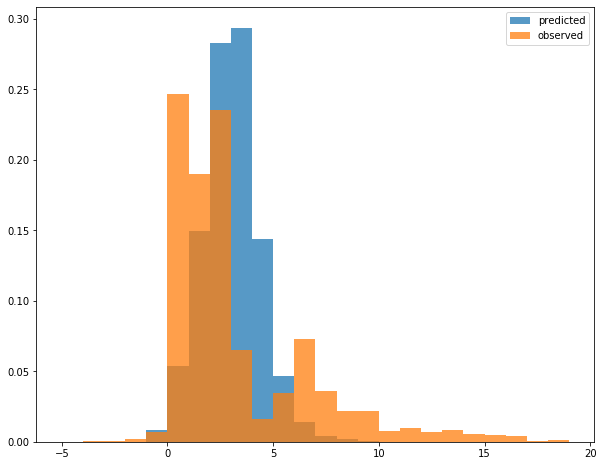

In [50]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ls_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

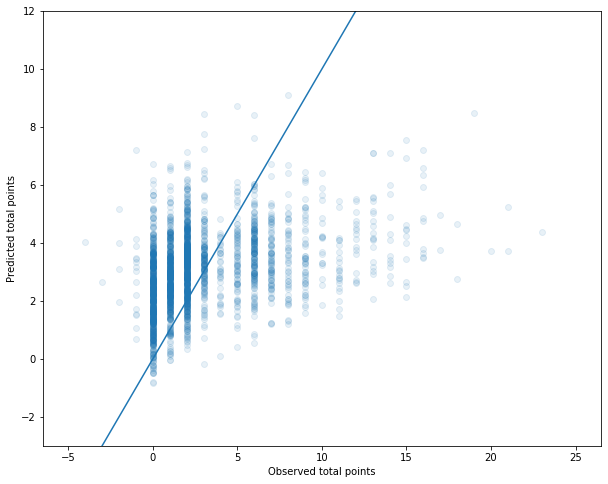

In [51]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ls_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge

In [52]:
ridge_model = Ridge(alpha=30)

ridge_model.fit(ridge_X_train_sel, y_train.ravel())

Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [53]:
# get predictions for train set
ridge_y_pred_train = ridge_model.predict(ridge_X_train_sel).flatten()

# calculate cross entropy loss for train set
ridge_train_loss = (
    mean_absolute_error(y_train, ridge_y_pred_train),
    mean_squared_error(y_train, ridge_y_pred_train),
    r2_score(y_train, ridge_y_pred_train)
)
ridge_train_loss

(2.3968820426114803, 10.042892866045076, 0.12511397362097998)

In [54]:
# get predictions for test set
ridge_y_pred = ridge_model.predict(ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
ridge_test_loss = (
    mean_absolute_error(y_test, ridge_y_pred),
    mean_squared_error(y_test, ridge_y_pred),
    r2_score(y_test, ridge_y_pred)
)
ridge_test_loss

(2.3731282904196824, 10.150207018148045, 0.1294305241478756)

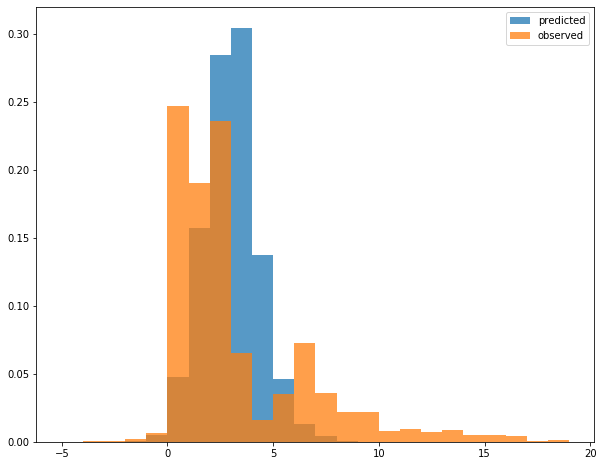

In [55]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

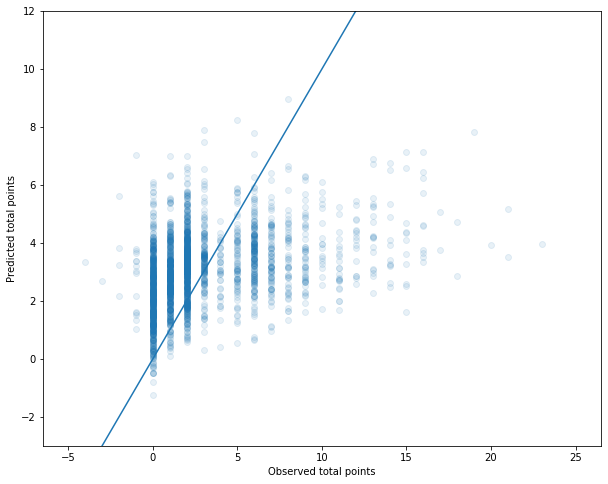

In [56]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Lasso

In [57]:
lasso_model = Ridge(alpha=0.01)

lasso_model.fit(lasso_X_train_sel, y_train.ravel())

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [58]:
# get predictions for train set
lasso_y_pred_train = lasso_model.predict(lasso_X_train_sel).flatten()

# calculate cross entropy loss for train set
lasso_train_loss = (
    mean_absolute_error(y_train, lasso_y_pred_train),
    mean_squared_error(y_train, lasso_y_pred_train),
    r2_score(y_train, lasso_y_pred_train)
)
lasso_train_loss

(2.382119412589482, 9.959140425617914, 0.13241006258480859)

In [59]:
# get predictions for test set
lasso_y_pred = lasso_model.predict(lasso_X_test_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss = (
    mean_absolute_error(y_test, lasso_y_pred),
    mean_squared_error(y_test, lasso_y_pred),
    r2_score(y_test, lasso_y_pred)
)
lasso_test_loss

(2.3987222400431754, 10.316127003113582, 0.11519979229318722)

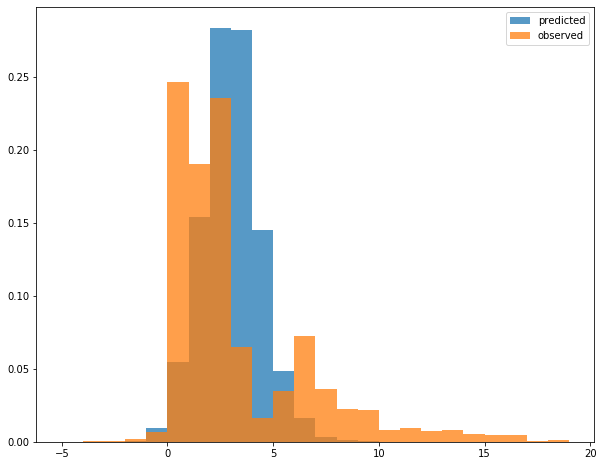

In [61]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

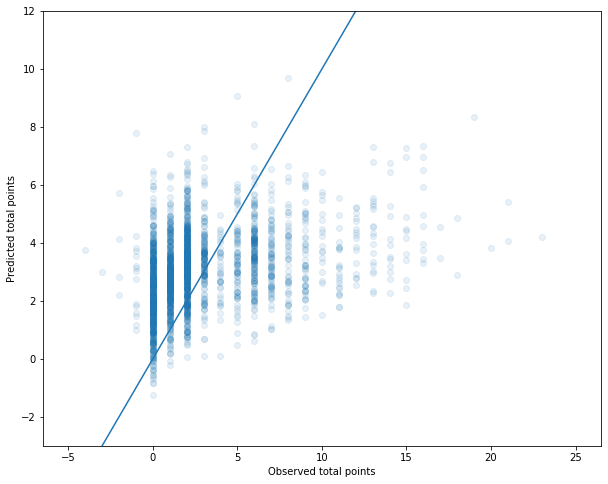

In [62]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(lasso_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [65]:
print('test loss')
print('test observations', len(y_test))
pd.DataFrame([
    ('Least squares', ls_test_loss[0], ls_test_loss[1], ls_test_loss[2]),
    ('Ridge', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

test loss
test observations 2264


,model,MAE,MSE,r2
0,Least squares,2.390223,10.214278,0.123935
1,Ridge,2.373128,10.150207,0.129431
2,Lasso,2.398722,10.316127,0.115200


In [70]:
(300*6.14 + 2146*10.35) / (300 + 2146)

9.833646770237122

In [67]:
print('train loss')
print('train observations', len(y_train))
pd.DataFrame([
    ('Least squares', ls_train_loss[0], ls_train_loss[1], ls_train_loss[2]),
    ('Ridge', ridge_train_loss[0], ridge_train_loss[1], ridge_train_loss[2]),
    ('Lasso', lasso_train_loss[0], lasso_train_loss[1], lasso_train_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

train loss
train observations 4329


,model,MAE,MSE,r2
0,Least squares,2.387170,9.977439,0.130816
1,Ridge,2.396882,10.042893,0.125114
2,Lasso,2.382119,9.959140,0.132410
